# Telco Churn Classification Project

### Kwame Taylor, Darden Cohort, Sept 2020

Welcome!

# Project Plan

This project will use statistical testing and classification to create 3 models predict churn better than the baseline model, and see which of those 3 models is most accurate.

I will create an MVP and then iterate through the data science pipeline until I get to the evaluation stage, which I will only do once.

The deliverables are the following:
telco-churn-classification-project.ipynb, README.md, predictions.csv, acquire.py, prepare.py, model.py, notebook walkthrough.

### Data Dictionary:

churn: 0 = Customer has not churned, 1 = Customer has churned

contract_type: 0 = Month-to-Month, 2 = Yearly, 3 = Two Year

depend: 0 = No dependents, 1 = Customer has dependents

num_add_ons: Number of add-on services a customer has

is_male: 1 if customer is male, 0 = female

internet_type: 0 = No internet, 2 = DSL, 3 = Fiber Optic

monthly_charges: The customer's monthly bill

tenure: Tenure in months.

tenure_yrs: Tenure in years

### Hypothesises:
 * Churn is highest in month-to-month contracts.
 * There is a significant difference in churn between cohorts identified by tenure.
 * There is a linear relationship between monthly charges and internet service type plus phone service type.

#### Start with importing all necessary modules.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from math import sqrt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from acquire import get_telco_data, new_telco_data
from prepare import prep_telco, telco_split

import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(10, 8))
plt.rc('font', size=14)

# Acquire

In Your Notebook - run acquire.py

 * summarize data (.info(), .describe(), .value_counts(), ...)

 * plot distributions of individual variables

### Use acquire.py to get the Telco churn customer data from local CSV (if cached) or the Codeup SQL database.

In [2]:
# import acquire.py and use get_telco_data() to acquire data
# if I want to replace my cached/local csv file with a fresh copy from SQL, I can use the function new_telco_data

df = get_telco_data()
df.head(3)

,customer_id,contract_type_id,phone_service,internet_service_type_id,gender,senior_citizen,partner,dependents,tenure,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,monthly_charges,total_charges,churn
0,0002-ORFBO,2,Yes,1,Female,0,Yes,Yes,9,No,Yes,No,Yes,Yes,No,65.6,593.3,No
1,0003-MKNFE,1,Yes,1,Male,0,No,No,9,No,No,No,No,No,Yes,59.9,542.4,No
2,0004-TLHLJ,1,Yes,2,Male,0,No,No,4,No,No,Yes,No,No,No,73.9,280.85,Yes


#### These are the columns I have decided are relevant to acquire from the SQL data to use in exploration. If I don't need them all I can drop them when the time comes.

In [3]:
df.columns

Index(['customer_id', 'contract_type_id', 'phone_service',
       'internet_service_type_id', 'gender', 'senior_citizen', 'partner',
       'dependents', 'tenure', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'monthly_charges', 'total_charges', 'churn'],
      dtype='object')

# Prepare

### Use prepare.py to clean up the data and make it easy to work with.

In [4]:
# import prepare.py and use prep_telco to prepare the data for use

df = prep_telco()
df.head(3)

,contract_type,phone,internet_type,senior,partner,depend,tenure,monthly_charges,total_charges,churn,num_add_ons,is_male,tenure_yrs
customer_id,,,,,,,,,,,,,
0002-ORFBO,1,1,0,0,1,1,9,65.6,593.3,0,3,0,0.75
0003-MKNFE,0,1,0,0,0,0,9,59.9,542.4,0,1,1,0.75
0004-TLHLJ,0,1,1,0,0,0,4,73.9,280.85,1,1,1,0.33


### Changes made to the data:
 * Set the index to be customer_id.
 * Encode non-numeric variables by mapping the strings into 1s and 0s.
 * Combine the variables for add-on packages into one new column, num_add_ons, that adds up the number of add-on services each customer has, and 0 if the customer has no add-ons or doesn't have internet.
 * Drop the add-on package columns we don't need anymore.
 * Encode gender, Male = 1 and Female = 0, and put in new column, is_male.
 * Drop the gender column.
 * Re-map contract_type_id and internet_service_type_id from values 1 to 3 into values 0 to 2:
  * Monthly = 0, Yearly = 1, Two Year = 2
  * 0 = No Internet Service, 1 = DSL, 2 = Fiber Optic
 * Add a column called tenure_yrs that represents tenure in years.
 * Rename columns to shorter names for readability and ease of use:
  * contract_type_id --> contract_type
  * phone_service --> phone
  * internet_service_type_id --> internet_type
  * senior_citizen --> senior
  * dependents --> depend

### Now I'll just make sure there are no missing values.

In [5]:
df.isna().sum()

contract_type      0
phone              0
internet_type      0
senior             0
partner            0
depend             0
tenure             0
monthly_charges    0
total_charges      0
churn              0
num_add_ons        0
is_male            0
tenure_yrs         0
dtype: int64

### No missing values. The data is tidy and ready to split into train, validate, and test.

In [6]:
# split the data using telco_split from my prepare.py

train, validate, test = telco_split(df)

print('overall shape', df.shape)
print('train', train.shape)
print('validate', validate.shape)
print('test', test.shape)

overall shape (7043, 13)
train (3943, 13)
validate (1691, 13)
test (1409, 13)


### Now the data is ready for exploration. We will work only within the train dataset in the next step.

# Explore

## If a group is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts?

$
\begin{align*}
   H_0 & : \text{There is no difference in churn between cohorts identified by tenure.}
   \\
   H_a & : \text{There is a significant difference in churn between cohorts identified by tenure.}
   \\
    \alpha & : \text{0.05}
\end{align*}
$

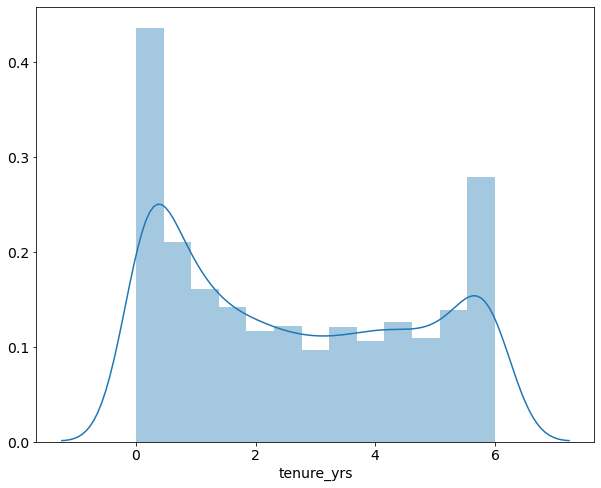

In [7]:
# Take a look at the spread of the tenure so I can determine how I want to split the cohorts.
train.tenure_yrs.describe()

# Distribution of Tenure (in years) amongst all customers
sns.distplot(train.tenure_yrs)

In [8]:
# I will use pd.cut to create bins for me. Looking at my visualization, I think 5 groups would be most useful to explore.
# I can choose to drop this from my train set at the end of exploration.

train['tenure_cohorts'] = pd.cut(train.tenure_yrs, 5, labels=['0 to 1.2 Years', '1.2 to 2.4 Years', '2.4 to 3.6 Years', '3.6 to 4.8 Years', '4.8 to 6.0 Years'])

[Text(0, 0.5, 'Churn Rate'),
 Text(0.5, 0, 'Tenure Cohorts'),
 Text(0.5, 1.0, 'Churn Rates Grouped by Tenure Cohort')]

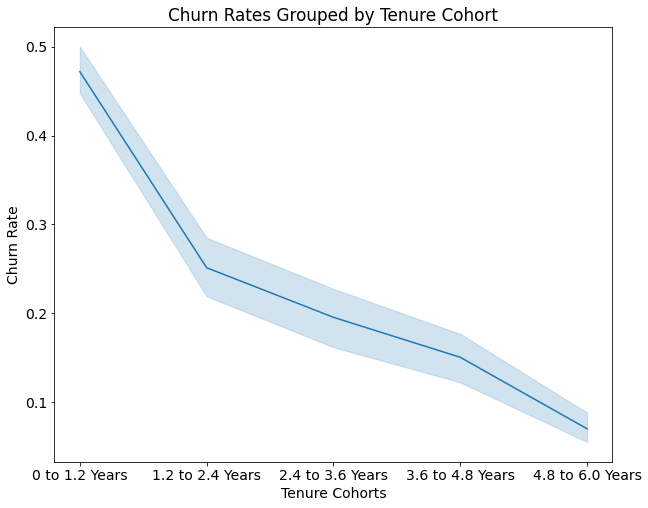

In [9]:
# Plot the rate of churn on a line chart
# where x is the tenure and y is the rate of churn (customers churned/total customers)

cohort_viz1 = sns.lineplot(data=train, x=train.tenure_cohorts, y=train.churn)
cohort_viz1.set(xlabel="Tenure Cohorts", ylabel = "Churn Rate", title = "Churn Rates Grouped by Tenure Cohort")

### Now I'll run Chi-Square test on the hypothesis:

In [10]:
# contingency table
observed = pd.crosstab(train.churn, train.tenure_cohorts)
observed

tenure_cohorts,0 to 1.2 Years,1.2 to 2.4 Years,2.4 to 3.6 Years,3.6 to 4.8 Years,4.8 to 6.0 Years
churn,,,,,
0,715,465,453,452,812
1,639,156,110,80,61


$
\begin{align*}
   H_0 & : \text{There is no difference in churn between cohorts identified by tenure.}
   \\
   H_a & : \text{There is a significant difference in churn between cohorts identified by tenure.}
   \\
    \alpha & : \text{0.05}
\end{align*}
$

In [11]:
alpha = 0.05

In [12]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

null_hypothesis = "there is no difference in churn between cohorts identified by tenure."

if p < alpha:
    print("We reject the hypothesis that", null_hypothesis)
else:
    print("We fail to reject the null hypothesis.")

print(p)

We reject the hypothesis that there is no difference in churn between cohorts identified by tenure.
6.72704628371419e-111


### We reject the null hypothesis, meaning that we can work off the assumption of a relationship between cohorts as split by tenure and their churn rates.

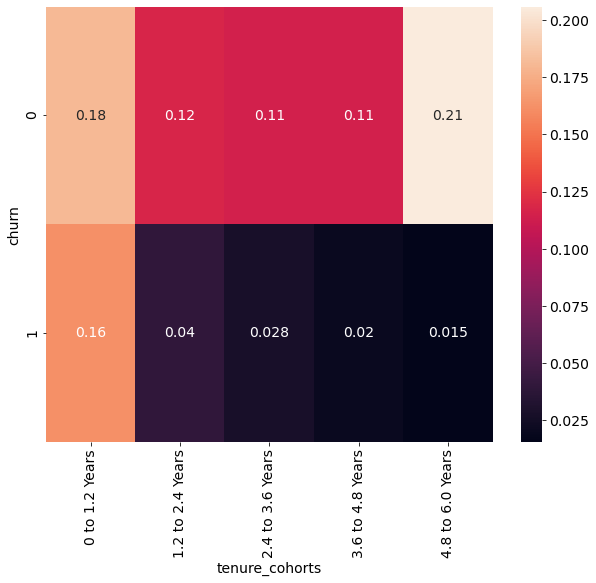

In [13]:
observed = pd.crosstab(train.churn, train.tenure_cohorts, normalize=True)
sns.heatmap(observed, annot=True)

### Generally, people who stay with the company longer have lower churn rates, and vice versa.

## Are there features that indicate a higher propensity to churn?

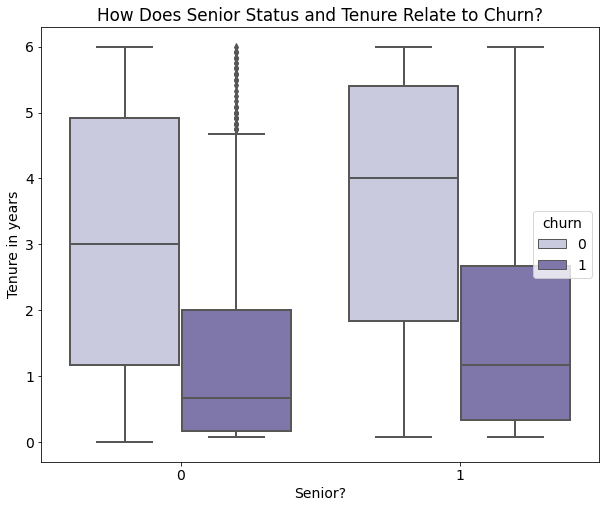

In [14]:
sns.boxplot(x='senior', y='tenure_yrs', data=train, hue='churn', palette='Purples', linewidth=2)

plt.title('How Does Senior Status and Tenure Relate to Churn?')
plt.xlabel('Senior?')
plt.ylabel('Tenure in years')
plt.show()

### I was expecting a bigger difference in churn between the senior/not senior groups, so I will move my focus to exploring other features.

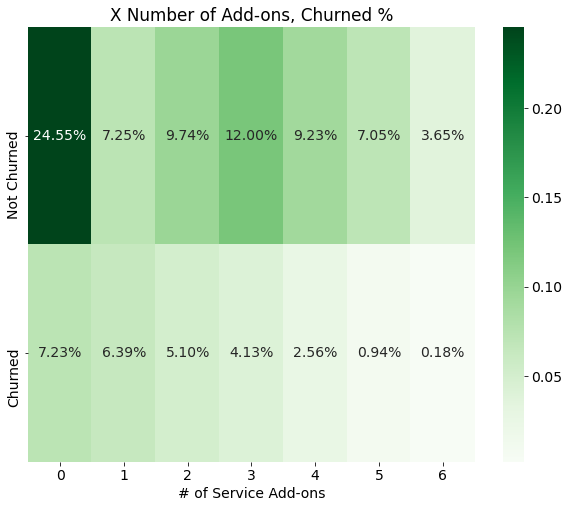

In [15]:
# Visualize the churn rates of customers by number of add-on services they have/had.
ctab = pd.crosstab(train.churn, train.num_add_ons, normalize=True)
sns.heatmap(ctab, annot=True, cmap='Greens', fmt='.2%')
plt.title('X Number of Add-ons, Churned %')
plt.xlabel('# of Service Add-ons')
plt.ylabel('')
locs, labels = plt.yticks()
plt.yticks(locs, ('Not Churned', 'Churned'))
plt.show()

### This heatmap tells me that many customers stay with Telco despite having no add-ons (or no internet). That said, the highest churn rate belongs to customers who do not have add-ons or do not have internet. The heatmap also visualizes (as you can see by the range of the gradients from left to right) that churn goes continually down with more add-ons.

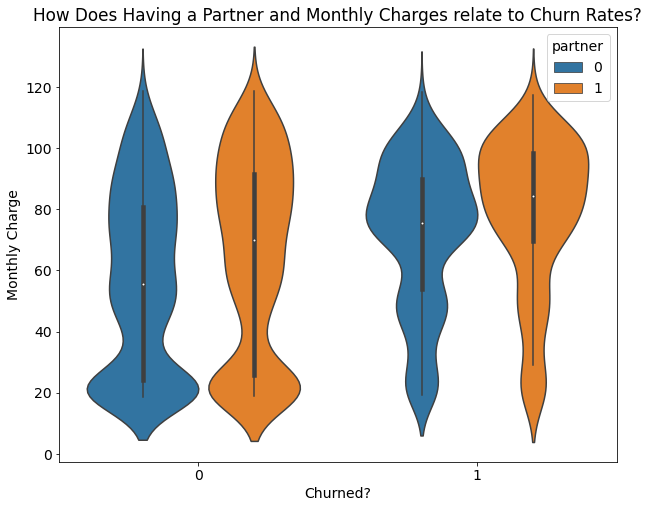

In [16]:
sns.violinplot(x='churn', y='monthly_charges', data=train, hue='partner')

plt.title('How Does Having a Partner and Monthly Charges relate to Churn Rates?')
plt.xlabel('Churned?')
plt.ylabel('Monthly Charge')

plt.show()

### Having a partner doesn't seem to have a huge affect on churn rate, although it does tend to make a customer spend more.

### Monthly charges look like the biggest driver of churn so far.

## If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

In [17]:
m2m = train[train['contract_type'] == 0]
m2m_12month = m2m[m2m['tenure'] == 12]

one_yr = train[train['contract_type'] == 1]
one_yr_12month = one_yr[one_yr['tenure'] == 12]

print('The average rate of churn amongst month-to-month customers after the 12th month is', m2m_12month.churn.mean())
print('\nThe average rate of churn amongst yearly customers after the 12th month is', round(one_yr_12month.churn.mean(), 2))

The average rate of churn amongst month-to-month customers after the 12th month is 0.42

The average rate of churn amongst yearly customers after the 12th month is 0.29


### The churn rates of month-to-month customers after the 12th month and yearly customers after the 12th month are not comparable.

## How much of monthly_charges can be explained by internet_service_type?

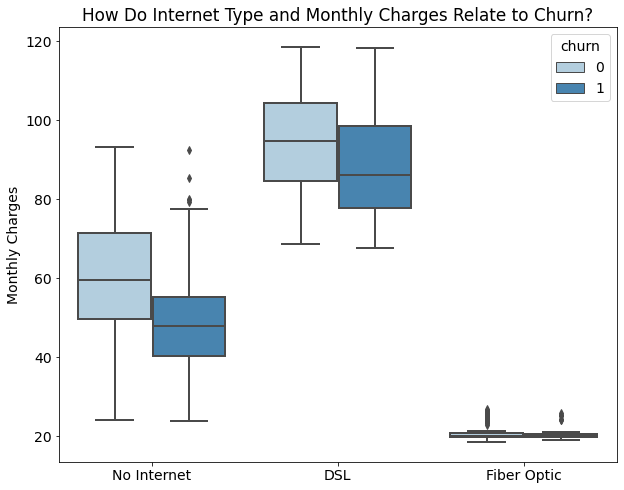

In [18]:
sns.boxplot(x='internet_type', y='monthly_charges', data=train, hue='churn', palette='Blues', linewidth=2)

plt.title('How Do Internet Type and Monthly Charges Relate to Churn?')
plt.xlabel('')
plt.ylabel('Monthly Charges')
locs, labels = plt.xticks()
plt.xticks(locs, ('No Internet', 'DSL', 'Fiber Optic'))
plt.show()

### Monthly charges of customers with no internet have similar ranges, but customers with no internet who churned had lower median monthly charges.

### This tells me that those people could have left the company for reasons other than monthly charge, like maybe choosing to get their internet service elsewhere and ending up switching their phone lines to that company as well.

## How much of monthly_charges can be explained by internet_service_type + phone_service_type (0, 1, or multiple lines).

$
\begin{align*}
   H_0 & : \text{There is no linear relationship between monthly charges and internet service type plus phone service type.}
   \\
   H_a & : \text{There is a linear relationship between monthly charges and internet service type plus phone service type.}
   \\
    \alpha & : \text{0.05}
\end{align*}
$

### In data prep I chose to change the phone_service_type to just phone because there were very few customers with multiple lines. I used my judgement to call that statistically irrelevant to the scope and goals of my project.

In [19]:
n = train.shape[0]
degf = n - 2
conf_interval = .95
alpha = .05

In [20]:
train['num_services'] = (train.internet_type + train.phone)

In [21]:
x = train.num_services
y = train.monthly_charges

def stdev(x):
    variance = ((x - x.mean()) ** 2).sum() / n
    return sqrt(variance)

# 1 = perfect correlation and -1 = perfect negative correlation.

r_xy = (((x - x.mean()) * (y - y.mean())).sum() / n) / (stdev(x) * stdev(y))
print("Pearson's correlation coefficient:", r_xy)

Pearson's correlation coefficient: -0.18243283931420629


In [22]:
t = (r_xy * sqrt(n - 2)) / sqrt(1 - r_xy**2)
print("Test statistic:", t)

Test statistic: -11.648131745260457


In [23]:
p = stats.t.sf(t, df=degf) * 2 # *2 for a two-tailed test
print("p-value:", p)

p-value: 2.0


In [24]:
null_hypothesis = "there is no linear relationship between monthly charges and internet service type plus phone service type."

if p < alpha:
    print("We reject the hypothesis that", null_hypothesis)
else:
    print("We fail to reject the null hypothesis.")

We fail to reject the null hypothesis.


### We fail to reject the null hypothesis, showing that there is no linear relationship between amount of phone and internet services and monthly charges.
### This is probably a big source of discontentment amongst customers, because they should be getting their money's worth.

## Data Exploration Summary:
 * #### There is significant difference in churn between cohorts identified by tenure.
 * #### Customers who stay with the company longer have lower churn rates, and vice versa.
 * #### A customer being a senior or having a partner is relatively irrelevant to whether or not they churn.
 * #### People with more service package add-ons churn less.
 * #### Customers with partners spend a little more monthly.
 * #### The churn rates of month-to-month customers after the 12th month and yearly customers after the 12th month are not comparable.
 * #### Monthly charges of customers with no internet have similar ranges, but customers with no internet who churned had lower median monthly charges.
 * #### There is no linear relationship between amount of phone and internet services and monthly charges.
 * #### High monthly charges are a primary driver of churn.
 
### Focus points moving forward will be the features monthly_charges and num_add_ons.

# Modeling and Evaluation

In [25]:
# You are required to establish a baseline accuracy to determine if having a model is better than no model
# and train and compare at least 3 different models. Document these steps well.

In Your Notebook:

 * Feature Selection: Are there any variables that seem to provide limited to no additional information? If so, remove them.

 * Train (fit, transform, evaluate) multiple different models, varying the model type and hyperparameters.

 * Compare evaluation metrics across all the models, and select the ones you want to test using your validate dataframe.

 * Based on how your evaluation of your models using the train and validate datasets, choose your best model that you will try with your test data.

 * Test the final model (transform, evaluate) on your out-of-sample data (the testing data set). Summarize the performance. Interpret your results.

### Feature selection

In [26]:
# Drop variables we don't need
train = train.drop(columns=['tenure_cohorts', 'num_services', 'senior'])
train.head(3)

,contract_type,phone,internet_type,partner,depend,tenure,monthly_charges,total_charges,churn,num_add_ons,is_male,tenure_yrs
customer_id,,,,,,,,,,,,
2821-WARNZ,1,1,2,0,1,49,19.45,921.3,0,0,0,4.08
2720-WGKHP,0,1,1,0,0,2,94.00,181.7,1,2,1,0.17
2197-OMWGI,2,0,0,1,1,68,53.00,3656.25,0,4,0,5.67


### Train (fit, transform, evaluate) Models

Start by defining the baseline model.

### Baseline Model

In [27]:
# Find the baseline and it's accuracy

train.churn.value_counts()

0    2897
1    1046
Name: churn, dtype: int64

In [29]:
# Our positive case will be that a customer has Churned (1)
# Baseline model will predict (0) that a customer has not churned

baseline_model = pd.DataFrame(train)
baseline_model["baseline"] = baseline_model.churn.value_counts().index[0]
baseline_model = baseline_model.drop(columns=['contract_type', 'phone', 'internet_type', 'partner', 'depend',
       'tenure', 'monthly_charges', 'total_charges', 'num_add_ons',
       'is_male', 'tenure_yrs'])
baseline_model.head(3)

,churn,baseline
customer_id,,
2821-WARNZ,0,0
2720-WGKHP,1,0
2197-OMWGI,0,0


In [31]:
pd.crosstab(baseline_model.churn, baseline_model.baseline)

baseline,0
churn,
0,2897
1,1046


In [32]:
# tp is where we predict no churn and they do not churn
tp = 2897
tn = 0
fp = 1046
fn = 0

print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Negatives:", tn)
print("-------------")

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)

print("Accuracy of baseline model is", round(accuracy, 3))
print("Recall is", round(recall, 3))
print("Precision is", round(precision, 3))

True Positives: 2897
False Positives: 1046
False Negatives: 0
True Negatives: 0
-------------
Accuracy of baseline model is 0.735
Recall is 1.0
Precision is 0.735


Baseline accuracy to beat is 73.5% accuracy.

In [34]:
train.head(3)

,contract_type,phone,internet_type,partner,depend,tenure,monthly_charges,total_charges,churn,num_add_ons,is_male,tenure_yrs,baseline
customer_id,,,,,,,,,,,,,
2821-WARNZ,1,1,2,0,1,49,19.45,921.3,0,0,0,4.08,0
2720-WGKHP,0,1,1,0,0,2,94.00,181.7,1,2,1,0.17,0
2197-OMWGI,2,0,0,1,1,68,53.00,3656.25,0,4,0,5.67,0


### Model 2

In [35]:
# Create a new model

X2 = df[['contract_type','tenure_yrs', 'num_add_ons']]
y2 = df[['churn']]

X2_train_validate, X2_test, y2_train_validate, y2_test = train_test_split(X2, y2, test_size = .20, random_state = 666)

X2_train, X2_validate, y2_train, y2_validate = train_test_split(X2_train_validate, y2_train_validate, test_size = .30, random_state = 666)

print("train: ", X2_train.shape, ", validate: ", X2_validate.shape, ", test: ", X2_test.shape)
print("train: ", y2_train.shape, ", validate: ", y2_validate.shape, ", test: ", y2_test.shape)

train:  (3943, 3) , validate:  (1691, 3) , test:  (1409, 3)
train:  (3943, 1) , validate:  (1691, 1) , test:  (1409, 1)


In [37]:
# Create the logistic regression object
logit = LogisticRegression(C=1, random_state=666)

In [38]:
# Fit the model to the training data

logit.fit(X2_train, y2_train)

LogisticRegression(C=1, random_state=666)

In [39]:
# Print the coefficients and intercept of the model

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-1.30106372 -0.30857264  0.18898971]]
Intercept: 
 [-0.10623263]


In [40]:
# Estimate whether or not a custoemr would churn, using the training data

y2_pred = logit.predict(X2_train)
#y2_pred
# above commented out unless you want a bunch of zeros and ones on your screen

In [41]:
# Estimate the probability of a customer churning, using the training data

y2_pred_proba = logit.predict_proba(X2_train)

In [42]:
# Evaluate Model on Train

# Compute the accuracy
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X2_train, y2_train)))

Accuracy of Logistic Regression classifier on training set: 0.75


#### 75% accuracy is better than our baseline model accuracy of 73.5%.

### Model 3

In [43]:
# Create new model

X3 = df[['monthly_charges']]
y3 = df[['churn']]

X3_train_validate, X3_test, y3_train_validate, y3_test = train_test_split(X3, y3, test_size = .20, random_state = 666)

X3_train, X3_validate, y3_train, y3_validate = train_test_split(X3_train_validate, y3_train_validate, test_size = .30, random_state = 666)

print("train: ", X3_train.shape, ", validate: ", X3_validate.shape, ", test: ", X3_test.shape)
print("train: ", y3_train.shape, ", validate: ", y3_validate.shape, ", test: ", y3_test.shape)

train:  (3943, 1) , validate:  (1691, 1) , test:  (1409, 1)
train:  (3943, 1) , validate:  (1691, 1) , test:  (1409, 1)


In [44]:
# Create the logistic regression object
logit2 = LogisticRegression(C=1, random_state=666)

In [45]:
# Fit the model to the training data

logit2.fit(X3_train, y3_train)

LogisticRegression(C=1, random_state=666)

In [46]:
# Print the coefficients and intercept of the model

print('Coefficient: \n', logit2.coef_)
print('Intercept: \n', logit2.intercept_)

Coefficient: 
 [[0.01514213]]
Intercept: 
 [-1.9950211]


In [47]:
# Estimate whether or not a customer would churn, using the training data

y3_pred = logit2.predict(X3_train)

In [48]:
# Estimate the probability

y3_pred_proba = logit2.predict_proba(X3_train)

In [49]:
# Evaluate Model on Train

# Compute the accuracy
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit2.score(X3_train, y3_train)))

Accuracy of Logistic Regression classifier on training set: 0.72


#### This model has 72% accuracy, so it performs below our baseline model of 73.5%.

### Evaluation Metrics

In [55]:
# prediction comes first this time so we can make our positive case a Defect duck.

print('Model 2')
print("Confusion matrix:\n", confusion_matrix(y2_train, y2_pred))
print("Classification report:\n", classification_report(y2_train, y2_pred))

print('Model 3')
print("Confusion matrix:\n", confusion_matrix(y3_train, y3_pred))
print("Classification report:\n", classification_report(y3_train, y3_pred))

Model 1
Confusion matrix:
 [[2642  215]
 [ 753  333]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.85      2857
           1       0.61      0.31      0.41      1086

    accuracy                           0.75      3943
   macro avg       0.69      0.62      0.63      3943
weighted avg       0.73      0.75      0.72      3943

Model 2
Confusion matrix:
 [[2857    0]
 [1086    0]]
Classification report:
               precision    recall  f1-score   support

           0       0.72      1.00      0.84      2857
           1       0.00      0.00      0.00      1086

    accuracy                           0.72      3943
   macro avg       0.36      0.50      0.42      3943
weighted avg       0.53      0.72      0.61      3943



### Choose Best Model and Test

#### Which model performs best on your out-of-sample data, the validate set?

In [60]:
print('Baseline/model 1 accuracy is 0.73')
print('Accuracy of Model 2 Logistic Regression classifier on validation set: {:.2f}'
     .format(logit.score(X2_validate, y2_validate)))
print('Accuracy of Model 3 Logistic Regression classifier on validation set: {:.2f}'
     .format(logit2.score(X3_validate, y3_validate)))

Baseline/model 1 accuracy is 0.73
Accuracy of Model 2 Logistic Regression classifier on validation set: 0.76
Accuracy of Model 3 Logistic Regression classifier on validation set: 0.74


The best model was Model 2, so I'll test that model on the Test data.

In [61]:
print('Baseline/model 1 accuracy is 0.73')
print('Accuracy of Model 2 Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(X2_test, y2_test)))
print('Accuracy of Model 3 Logistic Regression classifier on test set: {:.2f}'
     .format(logit2.score(X3_test, y3_test)))

Baseline/model 1 accuracy is 0.73
Accuracy of Model 2 Logistic Regression classifier on test set: 0.76
Accuracy of Model 3 Logistic Regression classifier on test set: 0.75


### The best model was the logistic regression model with features 'contract_type','tenure_yrs', 'num_add_ons'

# Conclusions

### * Churn's primary drivers are contract type, tenure, monthly charges, and number of add-on services.
### * Linear regression model with 'contract_type','tenure_yrs', 'num_add_ons' performed the best
### * We can reduce churn by predicting which customers are about to churn and reaching out to those customers